## Advanced Sampling and Experimental Design

Monte-Carlo simulations based on randomized parameter sets are easy to create and prevents intoducing statistical bias by the sampling method ("pure basian approach").

They require however a large number of runs to make sure that the parameter space has been adequately covered by the sample set. This is a problem where model computation time is significant, which is very often the case.

A number of techniques have been developed to optimize the coverage of the parameter space. A selection of them is shown here.

Note: The example code uses the `pyDOE` library, see https://pythonhosted.org/pyDOE/randomized.html

In [1]:
import pyDOE as pydoe

import matplotlib.pyplot as plt
%matplotlib inline

## Pseudo-Random Sampling

In randomized sample sets, it may happen that the parameter values of a simulation run are similar or equal to parameters values of a previous, already calculated scenario. In this case, the gain of additional information is reduced.

To avoid this, so-called [pseudo-random distributions](https://en.wikipedia.org/wiki/Pseudo-random_number_sampling) are used. Of these techniques, only Latin Hypercube Sampling will be shown here. More sampling methods are provided by the [GNU Scientific Library](https://en.wikipedia.org/wiki/GNU_Scientific_Library) which provides information and functionality.


### Latin Hypercube Sampling

Good for:
+ you can afford a fixed number of runs
+ you need minimum statistical bias in a Monte-Carlo Simulation

Latin Hypercube sampling is often used to create data sets for use in Monte-Carlo simulations. The fundamental principle is to create a test plan, that provides optimal coverage of the range of all parameters under a given set of samples.

The principle is best described by a latin square, in which each row and each column must be filled:

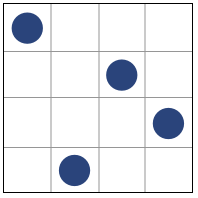



The test plan above covers the range of both parameters with 4 values each, using only 4 sample/simulation runs.

The latin Hypercube method is a generalization of this idea, working with an n-dimensional parameter space (hence hyper-cube). 

[[0.60972446 0.17225336]
 [0.58200472 0.15264338]]


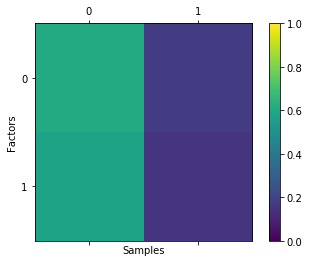

Latin-Hypercube Sampling (3 factors, 5 samples)


In [2]:
design = pydoe.lhs(n=2)
print(design.T)
plt.matshow(design.T, fignum=False, vmin=0, vmax=1)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.colorbar()
plt.show()
print("Latin-Hypercube Sampling (3 factors, 5 samples)")

Instead of discrete factor levels as above, a continuous distribution is provided.

LHS experiental designs are useful for higher dimensional tests.

[[0.58952033 0.21964257 0.92626897 0.7304922  0.13186813 0.36480165]
 [0.46124107 0.83571342 0.72614289 0.08644518 0.50270935 0.22707862]
 [0.87301783 0.40877237 0.21112037 0.09852353 0.54923608 0.80755056]
 [0.49784546 0.13497244 0.1818623  0.98215085 0.70803466 0.59406621]
 [0.9120529  0.74757998 0.04310825 0.59763297 0.22572315 0.38679387]]


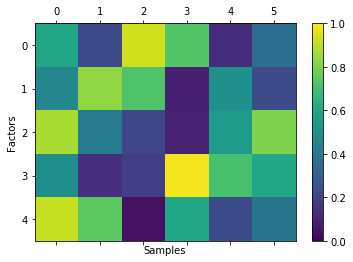

Latin-Hypercube Sampling (5 factors, 6 samples)


In [3]:
design = pydoe.lhs(n=5, samples=6)
print(design.T)
plt.matshow(design.T, fignum=False, vmin=0, vmax=1)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.colorbar()
plt.show()
print("Latin-Hypercube Sampling (5 factors, 6 samples)")

#### transforming factor levels to parameter values

The factor levels between 0 and 1 need to be translated into actual parameter values yet before they can be applied in the model.

Because the LHS provides a uniform distribution, we first need to transform them into a normal- or log-normal distrubtion first:

[[ 0.22631125 -0.09730757  1.14077313 -0.00540066  1.35350549]
 [-0.77340093  0.97699189 -0.23070404 -1.10318948  0.66689369]
 [ 1.44855442  0.60118884 -0.80253985 -0.90829079 -1.71570258]
 [ 0.61430229 -1.36297507 -1.29001034  2.10034722  0.24722506]
 [-1.11760374  0.00679139  0.12373153  0.54765229 -0.753006  ]
 [-0.34565327 -0.7485023   0.86890538  0.23801743 -0.28768517]]


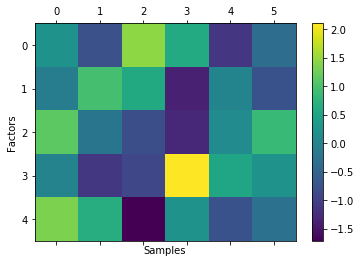

In [4]:
# scipy provides functions for statistical distributions
from scipy.stats.distributions import norm, lognorm

# transform the uniform distributed values to normal distributed
design_normaldist = norm().ppf(design)  
print(design_normaldist)

plt.matshow(design_normaldist.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.colorbar()
plt.show()

The values are now corresponding to the required PDF, but are still normed to mean value of zero and sigma = 1.

We therefore apply a scaling factor to get the correct distrutuion on the parameter axis:
Say we want to transform these designs to be normally distributed with means and standard deviations according to the spreadsheet we used earlier:

In [5]:
import pandas as pd
df_priorknowledge = pd.read_excel("./prior_knowledge.xlsx")
df_priorknowledge.set_index("parameter", inplace=True)
df_priorknowledge

,zone,PDF,mean,stdev
parameter,,,,
conductivity_body,Body,log-normal,8.6400,0.500000
conductivity_sealing,Sealing,log-normal,0.0864,0.632456
porosity,Domain,normal,0.2000,0.200000


In [6]:
pdfs = df_priorknowledge["PDF"].values  # vec
means = df_priorknowledge["mean"].values  # vector of mean values
stdvs = df_priorknowledge["stdev"].values  # vector of standard deviations.

With these values, we create a new LHS design with 3 factors and 250 model runs.

In [7]:
# create design (uniform distribution)
design = pydoe.lhs(n=3, samples=250)

In [8]:
# apply transformation / scaling according to spreadsheet
for i in range(len(df_priorknowledge)):
    if pdfs[i] == "normal":
        design[:, i] = norm(loc=means[i], scale=stdvs[i]**2).ppf(design[:, i])
    if pdfs[i] == "log-normal":
        design[:, i] = lognorm(s=stdvs[i], scale=means[i]).ppf(design[:, i])

**Remember to always visually inspect the generated distribution!!** 

Just typing in numbers is error prone and you may not find the mistake until after running the expensive simulations (or even worse: not at all).

Figure below compares the expected distribution to the realized one, but the more important check is if these distributions is what a field hydrogeologist would approve. 

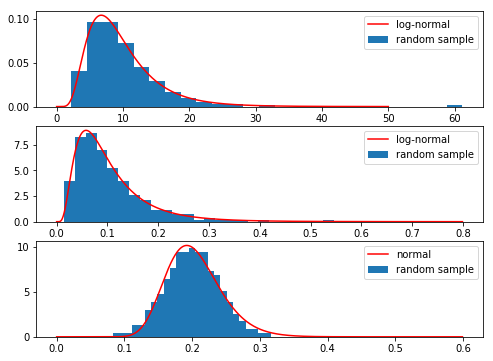

In [9]:
import numpy as np
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,6))

ax1.hist(design[:,0], bins=25, label="random sample", normed=True)
x = np.arange(0,50,0.001)
ax1.plot(x, lognorm(s=stdvs[0], scale=means[0]).pdf(x), "r-", label="log-normal", )
ax1.legend()

ax2.hist(design[:,1], bins=25, label="random sample", normed=True)
x = np.arange(0,0.8,0.001)
ax2.plot(x, lognorm(s=stdvs[1], scale=means[1]).pdf(x), "r-", label="log-normal", )
ax2.legend()

ax3.hist(design[:,2], bins=25, label="random sample", normed=True)
x = np.arange(0,0.6,0.001)
ax3.plot(x, lognorm(s=stdvs[2], scale=means[2]).pdf(x), "r-", label="normal", )
ax3.legend()



If these distributions look OK, we can create the same data frame from it that we previously used to run the Monte-Carlos simulation. 

In [10]:
# create a new data frame:
df_simulations = pd.DataFrame()

# add the vectors of parameter values as new columns to the data frame
df_simulations["conductivity_body"] = design[:,0]
df_simulations["conductivity_sealing"] = design[:,1]
df_simulations["porosity"] = design[:,2]

df_simulations

,conductivity_body,conductivity_sealing,porosity
0,7.704541,0.059627,0.163799
1,3.778405,0.055728,0.124198
2,11.254343,0.045254,0.224711
3,6.692874,0.112008,0.243269
4,7.329186,0.091377,0.207662
5,5.971593,0.080233,0.244070
6,8.021248,0.098465,0.261532
7,6.578651,0.335775,0.262394
8,17.578489,0.088341,0.169462
9,8.652246,0.137822,0.164171


## Experimental Test Designs

Monte-Carlo Tests require a certain minimum amounts of simulation runs to be successfully.
Ideally, your model should be designed to have a reasonable runtime that allows to conduct these runs in reasonable time.

Practically however, a model may not be able to do this (because it is too large, has become unstable) and we have to make do. Experimental designs can help here.

Experimental designs - also known as Design-of-Experiments (DoX or DoE) - have been originally developed in Chemical Engineering to optimize campaigns of (expensive and/or time-consuming) physical experiemnts. They are being applied in sensitivity analysis of numerical models as well.

An experimental design is typically a closed plan, which experiments / model runs are to be conducted. In most cases, the choice for these experiments only makes sense of the complete test plan is conducted.

### One-at-a-Time (OaaT) Design 

The probably most common design used in sensitivity analysis in groundwater modelling is the One-at-a-Time (OaaT) design. The test plans is conducted by running a base scenario (all parameters are at base value), and then changing a single parameter at a tiem to one or more factor levels different from the base levels.

Even though this is a very common strategy, it is not recommended as it has a number of shortcomings:
+ combined effects of two or more parameters cannot be determined
+ the variation of the model result is usually underestimated
+ a lot of unnecessary runs are taken, as most parameters combinations are almost identical

### Full-Factorial Design

A full-factorial design requires that for each parameter a certain number of factor levels is defined - often two (high or low) or three (high, mean or low), and then all possible combinations are being tested.

This obviously avoid a number of shortfalls of the OaaT approach, in particular the effect of every combination (at all order) can be determined. At the same time the effort increases fast with the number of parameters and factor level, thus that the method is only applicable to very low numbers of paramters.

The cost is also often unnecessary, as most high order combinations of parameters have no measurable effect on the result.

Example below shows a two-level design with 4 parameters, requiring 16 simulations to complete.

[[-1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.]]


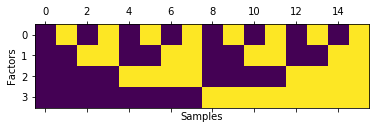

In [11]:
design = pydoe.ff2n(4)
print(design.T)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()

### Fractional Factorial

Good for:
+ long running models, limited time
+ sensitivity analysis (not uncertainty analysis)

A [fractional factorial](https://en.wikipedia.org/wiki/Fractional_factorial_design) design improves the efficiency of a test plan by making use of the usually irrelevant influence of high-order parameter interactions.

Take for example the case of a 3-parameter full-factorial design with parameter [a, b, c]:

The design can test the influence of 
+ all parameters - called main effects - (a,b,c), 
+ all first-level interactions (ab, ac, bc)
+ the second-level interaction (abc)

Significant influences of interactions are getting less likely the more parameters are involved.
Without showing the (somewhat lengthy) proof here, this can be used to our advantage.

Since we do not expect to find any correlation of the second order interaction with the model result, we can use this for testing an additional parameter. We simply set the factor level (here: -1 or 1) of the additional parameter following the factor level of the combination. This approach is called "folding".

As a result, we get one factor for free. The example below is the fractional factorial version of the full-factorial design above, with one parameter folded (d = abc). It can test the same parameters range with only half the number of model runs, at the cost of sacrificing detection of the (unlikely) three-parameter interaction.

[[-1.  1. -1.  1. -1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.  1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]]


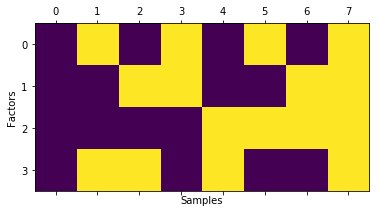

In [12]:
design = pydoe.fracfact('a b c abc')
print(design.T)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()

### Placket-Burman

[Plackett–Burman designs](https://en.wikipedia.org/wiki/Plackett–Burman_design) *are experimental designs presented in 1946 by Robin L. Plackett and J. P. Burman while working in the British Ministry of Supply.[1] Their goal was to find experimental designs for investigating the dependence of some measured quantity on a number of independent variables (factors), each taking L levels, in such a way as to minimize the variance of the estimates of these dependencies using a limited number of experiments. Interactions between the factors were considered negligible. The solution to this problem is to find an experimental design where each combination of levels for any pair of factors appears the same number of times, throughout all the experimental runs (refer to table). A complete factorial design would satisfy this criterion, but the idea was to find smaller designs.* 

*For the case of more than two levels, Plackett and Burman rediscovered designs that had previously been given by Raj Chandra Bose and K. Kishen at the Indian Statistical Institute.[4] Plackett and Burman give specifics for designs having a number of experiments equal to the number of levels L to some integer power, for L = 3, 4, 5, or 7.*

*When interactions between factors are not negligible, they are often confounded in Plackett–Burman designs with the main effects, meaning that the designs do not permit one to distinguish between certain main effects and certain interactions. This is called aliasing or confounding.*

from Wikipedia

[[ 1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.]
 [-1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.]
 [-1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.]
 [-1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.]
 [-1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1.]]


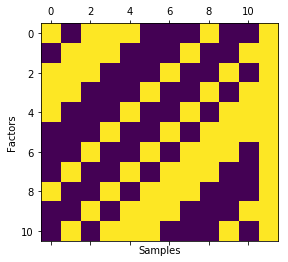

Placket-Burman Plan with 11 factors


In [13]:
design = pydoe.pbdesign(11)
print(design.T)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()
print("Placket-Burman Plan with 11 factors")

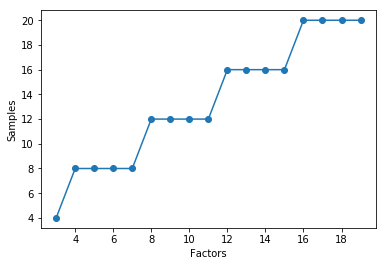

Effort of Placket-Burman designs with increasing factor number


In [14]:
plt.plot(range(3,20), [len(pydoe.pbdesign(n)) for n in range(3,20)], "o-")
plt.ylabel("Samples")
plt.xlabel("Factors")
plt.show()
print("Effort of Placket-Burman designs with increasing factor number")

### Box-Behnken Design (3-Factor Level)

Good for:
+ Model is reasonably fast or number of factors is low
+ It is supposed to look like a traditional sensitivity analysis (3 factor levels, OaaT design) 
+ sensitivity analysis
+ worst / best case testing

A Box-Behnken Design uses three factor levels (High, Mean, Low). Each pair-wise combination of parameters are tested (4 different combinations), while keeping all other parameters at center level.

The BB-Design can be seens as a compromise between a OaaT-Design and a fractional-factorial design. This makes it feasible where traditional sensitivity analysis is required by project specs. The Effort is significantly higher, but allows for testing parameter combinations of first level.

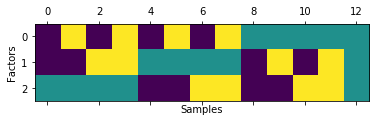

Box-Behnken Design with 3 factors 


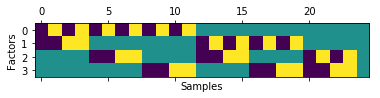

Box-Behnken Design with 4 factors 


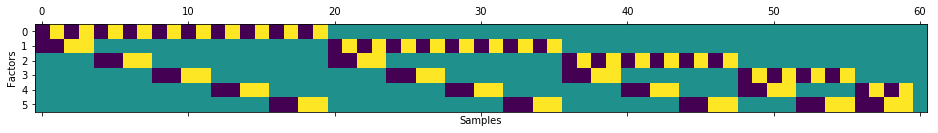

Box-Behnken Design with 6 factors 


In [15]:
# 3 factors
design = pydoe.bbdesign(3, center=1)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()
print("Box-Behnken Design with 3 factors ")

# 4 factors
design = pydoe.bbdesign(4, center=1)
plt.matshow(design.T, fignum=False)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()
print("Box-Behnken Design with 4 factors ")

# 5 factors
design = pydoe.bbdesign(6, center=1)
plt.matshow(design.T, fignum=15)
plt.xlabel("Samples")
plt.ylabel("Factors")
plt.show()
print("Box-Behnken Design with 6 factors ")

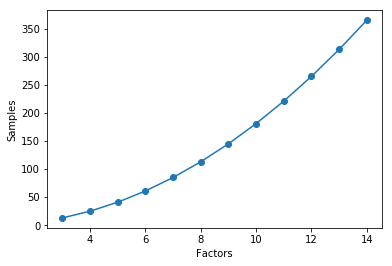

Effort of Box-Behnken designs with increasing factor number


In [16]:
plt.plot(range(3,15), [len(pydoe.bbdesign(n, center=1)) for n in range(3,15)], "o-")
plt.ylabel("Samples")
plt.xlabel("Factors")
plt.show()
print("Effort of Box-Behnken designs with increasing factor number")